In [ ]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
import statsmodels.api as sm
from skimage.filters import threshold_yen, threshold_otsu
from pyqupath.tiff import TiffZarrReader
import os
import matplotlib.gridspec as gridspec
import networkx as nx
from scipy.spatial import Delaunay
from tqdm import tqdm
from collections import Counter 
import pickle
import re  # Import regex module
from scipy.stats import zscore
from scipy.cluster import hierarchy
from scipy.spatial import distance
from sklearn.preprocessing import StandardScaler
from matplotlib.patches import Patch
from scipy.signal import find_peaks
from matplotlib.lines import Line2D

# 1. Ensure text is editable in Illustrator
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

# 2. Optional: Ensure text is not converted to outlines in SVG (if you use SVG)
plt.rcParams['svg.fonttype'] = 'none'



In [ ]:
def plot_coefficients_clean(model_result, alpha=0.05, figsize=(10, 6), remove_intercept=True):
    df = pd.DataFrame({
        'coef': model_result.params,
        'err_lower': model_result.params - model_result.conf_int()[0],
        'err_upper': model_result.conf_int()[1] - model_result.params,
        'pval': model_result.pvalues
    })
    
    if remove_intercept:
        df = df.drop("Intercept", errors='ignore')
    
    # --- NEW: Clean the Labels ---
    # This regex finds text inside [] and joins them if there are multiple (for interactions)
    # e.g., "C(TMA)[T.Rochester]" -> "T.Rochester"
    # e.g., "C(A)[T.1]:C(B)[T.2]"  -> "T.1 : T.2"
    clean_labels = [
        " : ".join(re.findall(r'\[(.*?)\]', label)) if "[" in label else label 
        for label in df.index
    ]
    df.index = clean_labels
    # -----------------------------

    df['is_significant'] = df['pval'] < alpha
    
    fig, ax = plt.subplots(figsize=figsize)
    y_pos = np.arange(len(df))
    
    for i, (idx, row) in enumerate(df.iterrows()):
        color = 'firebrick' if row['is_significant'] else 'gray'
        ax.errorbar(x=row['coef'], y=i, xerr=[[row['err_lower']], [row['err_upper']]], 
                    fmt='o', color=color, capsize=5, markeredgewidth=2, markersize=8)
        
    ax.set_yticks(y_pos)
    ax.set_yticklabels(df.index) # Now uses the clean labels
    ax.invert_yaxis()
    ax.axvline(x=0, color='black', linestyle='--', linewidth=1, alpha=0.7)
    ax.set_xlabel("Coefficient Estimate (with 95% CI)")
    ax.set_title("Model Coefficients (HC3 Robust SE)")
    
    # Legend construction (same as before)
    legend_elements = [
        Line2D([0], [0], color='firebrick', marker='o', linestyle='-', label='Significant (p < 0.05)'),
        Line2D([0], [0], color='gray', marker='o', linestyle='-', label='Not Significant')
    ]
    ax.legend(handles=legend_elements, loc='best')
    
    plt.tight_layout()



The `annotation` and `scaled_df` dataframes are deposit on [Zenodo](10.5281/zenodo.18379156) under `06_figure_6_Single_Cell_Protein_Expression/DFCI_Rochester` with the same exact names. Here we load the data first. 

In [3]:
annotation = pd.read_csv('../data/FINAL_DF_with_raw_fxn.csv')

scaled_df = pd.read_csv('../data/FINAL_DF_with_scaled_fxn.csv')

In [4]:
annotation['TMA_crop'] = annotation['TMA'] + '_' + annotation['cropName']

Core level LMP1 status

In [5]:
LMP1_dict = {
    'DFCI_c02': 'LMP1-',
    'DFCI_c03': 'LMP1-',
    'DFCI_c05': 'LMP1+',
    'DFCI_C06': 'LMP1+',
    'DFCI_c09': 'LMP1-',
    'DFCI_c10': 'LMP1-',
    'DFCI_c11': 'LMP1+',
    'DFCI_c14': 'LMP1-',
    'DFCI_c17': 'LMP1-',
    'DFCI_c18': 'LMP1-',
    'DFCI_c23': 'LMP1-',
    'DFCI_c24': 'LMP1-',
    'DFCI_c26': 'LMP1-',
    'DFCI_c27': 'LMP1-',
    'DFCI_c28': 'LMP1-',
    'DFCI_c29': 'LMP1-',
    'DFCI_c31': 'LMP1-',
    'DFCI_c32': 'LMP1-',
    'DFCI_c34': 'LMP1-',
    'DFCI_c41': 'LMP1-',
    'DFCI_c12': 'LMP1+',
    'DFCI_c21': 'LMP1+',
    'DFCI_c33': 'LMP1-',
    'Rochester_c04': 'LMP1-',
    'Rochester_c07': 'LMP1-',
    'Rochester_c11': 'LMP1+',
    'Rochester_c15': 'LMP1-',
    'Rochester_c16': 'LMP1+',
    'Rochester_c17': 'LMP1-',
    'Rochester_c18': 'LMP1-',
    'Rochester_c20': 'LMP1-',
    'Rochester_c21': 'LMP1-',
    'Rochester_c22': 'LMP1-',
    'Rochester_c23': 'LMP1+',
    'Rochester_c25': 'LMP1-',
    'Rochester_c28': 'LMP1+',
    'Rochester_c29': 'LMP1-',
    'Rochester_c06': 'LMP1-',
    'Rochester_C04': 'LMP1+'
}

In [6]:
annotation['LMP1_status'] = annotation['TMA_crop'].map(LMP1_dict)

## Identify C1Q+ Macrophages

In [7]:
macro_df = annotation[annotation['Annotation'] == 'Macrophage'].copy()

First mark cores in which C1Q stained bad. 

In [8]:
c1q_filter = ['DFCI_c05', 'Rochester_c22', 'DFCI_c21', 'DFCI_c41']

macro_df = macro_df[~macro_df['TMA_crop'].isin(c1q_filter)]

In [9]:
macro_df

,Unnamed: 0,TMA,coreName,cropName,EBV,cellLabel,Annotation,X_cent,Y_cent,CD3,...,CD68,CD163,CD206,DAPI_0,LMP1,LAG3,C1q,Myc,TMA_crop,LMP1_status
651611,651611,DFCI,2.1,c02,EBV+,6,Macrophage,1910.372973,119.594595,0.000000,...,0.108862,0.022332,0.007952,8454.383784,36.804094,96.019795,1841.795439,374.098606,DFCI_c02,LMP1-
651612,651612,DFCI,2.1,c02,EBV+,19,Macrophage,1887.410681,128.692449,0.000000,...,0.420286,0.063334,0.000817,5053.160221,4.463754,137.990965,5074.492634,838.464491,DFCI_c02,LMP1-
651613,651613,DFCI,2.1,c02,EBV+,20,Macrophage,1606.949664,129.516779,0.007282,...,0.077762,0.033031,0.009605,6988.171141,8.852252,55.424923,18408.080537,7752.161074,DFCI_c02,LMP1-
651614,651614,DFCI,2.1,c02,EBV+,22,Macrophage,1689.428571,130.779221,0.000000,...,0.070485,0.001017,0.000702,4726.948052,5.042381,69.552836,7765.476461,792.890929,DFCI_c02,LMP1-
651615,651615,DFCI,2.1,c02,EBV+,24,Macrophage,1980.703431,133.223039,0.011900,...,0.128476,0.023210,0.006832,5876.122549,6.084961,266.957970,24205.078431,6214.388480,DFCI_c02,LMP1-
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1509855,1509855,Rochester,5.0,c07,EBV+,71367,Macrophage,3634.871921,5180.443350,0.134522,...,0.152133,0.180167,0.324953,4859.699507,3.005790,35.482126,751.405172,844.797876,Rochester_c07,LMP1-
1509862,1509862,Rochester,7.0,c11,EBV+,27556,Macrophage,2023.176796,2041.828729,0.086529,...,0.276284,0.247111,0.298135,4572.657459,0.697575,7.943530,2170.199240,4.635588,Rochester_c11,LMP1+
1509863,1509863,Rochester,7.0,c11,EBV+,40268,Macrophage,4445.195286,2650.659933,0.151995,...,0.251450,0.130165,0.309668,5677.286195,3.704629,57.745864,8312.627104,324.320155,Rochester_c11,LMP1+
1509875,1509875,Rochester,8.0,c18,EBV-,8406,Macrophage,3622.084270,1060.370787,0.072091,...,0.146008,0.180207,0.328695,2779.994382,0.000000,0.061983,1005.831636,66.393258,Rochester_c18,LMP1-


In [10]:
yen_dict = {}
# Create output directory
output_dir = "../data/C1q_Analysis_Plots"
os.makedirs(output_dir, exist_ok=True)

# ROI List
roi_list = list(macro_df['TMA_crop'].unique())

for roi in roi_list:
    print(f"Processing: {roi}...")
    
    tma, crop = roi.split('_')
    
    # --- 1. Filter Data ---
    plot_data = scaled_df[
        (scaled_df['TMA'] == tma) & 
        (scaled_df['cropName'] == crop)
    ]
    
    if plot_data.empty:
        print(f"  Skipping {roi}: No data found.")
        continue

    # --- 2. Calculations ---
    log_data = np.log10(plot_data['C1q'] + 1e-6)
    thresh_yen = threshold_yen(log_data)
    yen_data = plot_data[plot_data['C1q'] > 10 ** thresh_yen]
    harsh_data = plot_data[plot_data['C1q'] > 10 ** (thresh_yen + 1)]
    
    log_hist = np.histogram(log_data, bins = 'auto')
    
    counts, bin_edges = log_hist

    counts, bin_edges = log_hist
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    # 2. Define the "valid" range (Excluding index 0 and index -1)
    # We slice from 1 to -1 (non-inclusive of the end)
    valid_counts = counts[1:-1]
    valid_centers = bin_centers[1:-1]

    # 3. Find the highest peak in this trimmed range
    # argmax gives the index relative to the sliced array
    max_idx = np.argmax(valid_counts)

    # 4. Get the values
    highest_peak_x = valid_centers[max_idx]

    yen_dict[roi] = np.max([highest_peak_x, thresh_yen])

    mid_data = plot_data[plot_data['C1q'] > 10 ** highest_peak_x]


    # --- 3. Setup Figure (Constrained Layout removes whitespace) ---
    fig = plt.figure(figsize=(16, 12), constrained_layout=True)
    
    # Create an outer grid with 2 rows: 
    # Row 0 (Top) is for histograms (shorter height)
    # Row 1 (Bottom) is for maps (taller height)
    outer_grid = gridspec.GridSpec(2, 1, figure=fig, height_ratios=[1, 2.5])
    
    fig.suptitle(f"Analysis for {roi}", fontsize=20, weight='bold')

    # --- TOP ROW: 3 Histograms ---
    # Create a 1x3 sub-grid inside the top row
    gs_top = outer_grid[0].subgridspec(1, 3)
    
    ax_hist1 = fig.add_subplot(gs_top[0])
    ax_hist2 = fig.add_subplot(gs_top[1])
    ax_hist3 = fig.add_subplot(gs_top[2])

    sns.histplot(plot_data['C1q'], ax=ax_hist1)
    ax_hist1.set_title('Raw Distribution')

    sns.histplot(log_data, ax=ax_hist2)
    ax_hist2.set_title('Log10 Distribution')

    sns.histplot(log_data, ax=ax_hist3)
    ax_hist3.axvline(thresh_yen, color='black', linestyle='--', linewidth=2, label=f'Yen: {thresh_yen:.2f}')
    ax_hist3.axvline(thresh_yen + 1, color='red', linestyle='--', linewidth=2, label=f'Yen + 1: {thresh_yen + 1:.2f}')
    ax_hist3.axvline(highest_peak_x, color='blue', linestyle='--', linewidth=2, label=f'2nd Peak: {highest_peak_x:.2f}')
    ax_hist3.set_title('Yen Threshold')
    ax_hist3.legend()


    # --- BOTTOM ROW: 2 Spatial Maps ---
    # Create a 1x2 sub-grid inside the bottom row
    gs_bottom = outer_grid[1].subgridspec(1, 4)
    
    ax_scatter1 = fig.add_subplot(gs_bottom[0])
    ax_scatter2 = fig.add_subplot(gs_bottom[1])
    ax_scatter3 = fig.add_subplot(gs_bottom[2])
    ax_image = fig.add_subplot(gs_bottom[3])

    try:
        img_path = f'../data/combined_img/{tma}/{crop}.ome.tiff'
        af_image = TiffZarrReader.from_ometiff(img_path)
        img_array = af_image.zimg_dict['C1q']
        h, w = img_array.shape

        # Scatter Plot
        ax_scatter1.scatter(
            yen_data['X_cent'], 
            yen_data['Y_cent'], 
            c=yen_data['C1q'], 
            cmap='rocket_r', 
            s=0.5, 
            alpha=0.7
        )
        ax_scatter1.set_xlim(0, w)
        ax_scatter1.set_ylim(h, 0) # Invert Y
        ax_scatter1.set_aspect('equal')
        ax_scatter1.set_title(f'Yen, {thresh_yen: .2f}', fontsize=14)

        # Scatter Plot
        ax_scatter2.scatter(
            mid_data['X_cent'], 
            mid_data['Y_cent'], 
            c=mid_data['C1q'], 
            cmap='rocket_r', 
            s=0.5, 
            alpha=0.7
        )
        ax_scatter2.set_xlim(0, w)
        ax_scatter2.set_ylim(h, 0) # Invert Y
        ax_scatter2.set_aspect('equal')
        ax_scatter2.set_title(f'2nd Peak, {highest_peak_x: .2f}', fontsize=14)

        # Scatter Plot
        ax_scatter3.scatter(
            harsh_data['X_cent'], 
            harsh_data['Y_cent'], 
            c=harsh_data['C1q'], 
            cmap='rocket_r', 
            s=0.5, 
            alpha=0.7
        )
        ax_scatter3.set_xlim(0, w)
        ax_scatter3.set_ylim(h, 0) # Invert Y
        ax_scatter3.set_aspect('equal')
        ax_scatter3.set_title(f'{thresh_yen + 1:.2f} Thresholded Points (Spatial)', fontsize=14)

        # Image Plot
        ax_image.imshow(img_array, cmap='gray', vmin=0, vmax=np.quantile(img_array, 0.99))
        ax_image.set_title('IF Image', fontsize=14)
        ax_image.set_aspect('equal')

    except Exception as e:
        ax_scatter.text(0.5, 0.5, "Error", ha='center')
        ax_image.text(0.5, 0.5, str(e), ha='center')

    # --- 4. Save ---
    save_path = os.path.join(output_dir, f"{roi}_analysis.png")
    plt.savefig(save_path, dpi=150) # constrained_layout handles the margins automatically
    plt.close(fig)

print("All plots saved with optimized layout.")


Processing: DFCI_c02...
Processing: DFCI_c03...
Processing: DFCI_c09...
Processing: DFCI_c10...
Processing: DFCI_c11...
Processing: DFCI_c14...
Processing: DFCI_c17...
Processing: DFCI_c18...
Processing: DFCI_c23...
Processing: DFCI_c24...
Processing: DFCI_c26...
Processing: DFCI_c27...
Processing: DFCI_c28...
Processing: DFCI_c29...
Processing: DFCI_c31...
Processing: DFCI_c32...
Processing: DFCI_c34...
Processing: DFCI_c12...
Processing: DFCI_C06...
Processing: DFCI_c33...
Processing: Rochester_c04...
Processing: Rochester_c07...
Processing: Rochester_c11...
Processing: Rochester_c15...
Processing: Rochester_c16...
Processing: Rochester_c17...
Processing: Rochester_c18...
Processing: Rochester_c20...
Processing: Rochester_c21...
Processing: Rochester_c23...
Processing: Rochester_c25...
Processing: Rochester_c28...
Processing: Rochester_c29...
Processing: Rochester_c06...
Processing: Rochester_C04...
All plots saved with optimized layout.


In [11]:
scaled_df['TMA_crop'] = scaled_df['TMA'] + '_' + scaled_df['cropName']

df_list = []

for crop in macro_df['TMA_crop'].unique():
    sub_df = scaled_df[scaled_df['TMA_crop'] == crop].copy()
    if crop in yen_dict.keys():
        thresh = yen_dict[crop]
        sub_df['C1q_status_sC'] = np.where(sub_df['C1q'] > 10 ** thresh, 'C1q+', 'C1q-')
        df_list.append(sub_df)


In [12]:

C1q_sC_df = pd.concat(df_list)

C1q_sC_df = C1q_sC_df[['TMA', 'cropName', 'cellLabel', 'C1q_status_sC']].copy()

C1q_sC_df

,TMA,cropName,cellLabel,C1q_status_sC
0,DFCI,c02,4,C1q-
1,DFCI,c02,10,C1q-
2,DFCI,c02,29,C1q+
3,DFCI,c02,37,C1q-
4,DFCI,c02,57,C1q+
...,...,...,...,...
1509851,Rochester,C04,38903,C1q-
1509852,Rochester,C04,38979,C1q-
1509853,Rochester,C04,39373,C1q-
1509854,Rochester,C04,39427,C1q-


In [13]:
C1q_sC_df.to_csv('../data/C1q_sC_df.csv')

Identify C1Q positive macrophages useing the scaled df. If C1Q >= Fianl threshold, identify as positive.

In [ ]:
macro_df = macro_df.merge(C1q_sC_df, 
                          on = ['TMA', 'cropName', 'cellLabel'],
                          how = 'left')

macro_df['C1q_status_sC'] = macro_df['C1q_status_sC'].fillna('C1q-')

## Identify LMP1+ and LMP1- cells. 

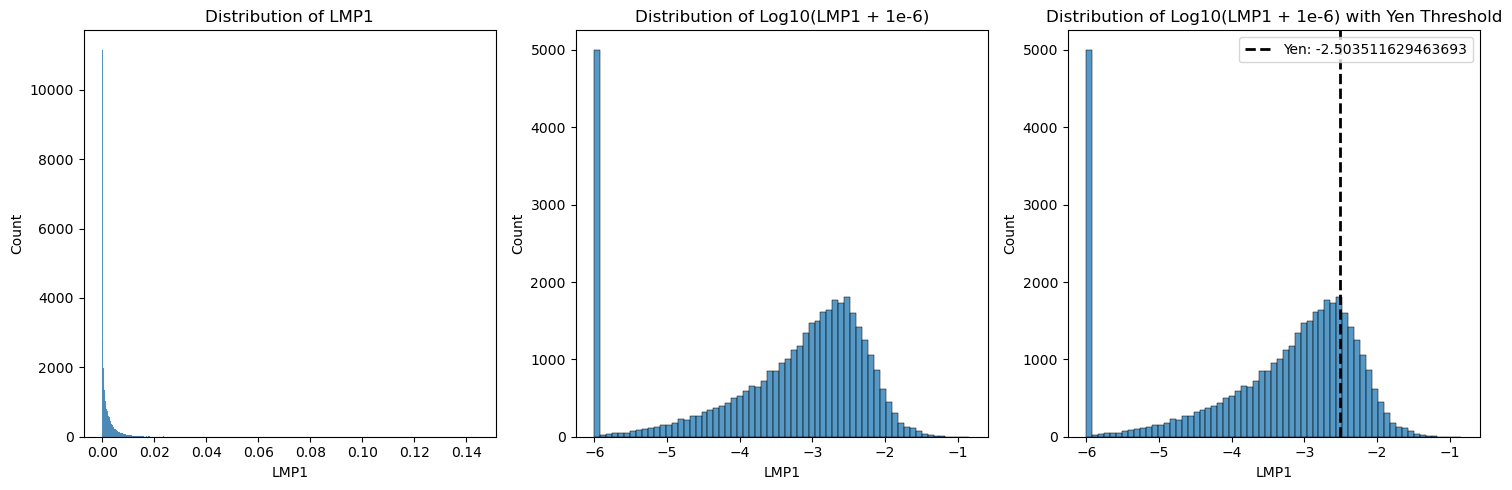

In [7]:
# 1. Filter the DataFrame for the specific TMA and Crop
plot_data = scaled_df[
    (scaled_df['TMA'] == 'Rochester') & 
    (scaled_df['cropName'] == 'C04')
]

data = np.log10(plot_data['LMP1'] + 1e-6)
thresh_yen = threshold_yen(data)

fig, axes = plt.subplots(1,3,figsize = (15,5))

sns.histplot(plot_data['LMP1'], ax = axes[0])
axes[0].set_title('Distribution of LMP1')

sns.histplot(np.log10(plot_data['LMP1'] + 1e-6), ax = axes[1])
axes[1].set_title('Distribution of Log10(LMP1 + 1e-6)')

sns.histplot(data, ax = axes[2])
plt.axvline(thresh_yen, color = 'black', linestyle = '--', linewidth = 2, label = f'Yen: {thresh_yen}')
axes[2].set_title('Distribution of Log10(LMP1 + 1e-6) with Yen Threshold')

plt.legend()
plt.tight_layout()
plt.show()

Inspect the thresholded data.

In [8]:
af_image = TiffZarrReader.from_ometiff('../data/combined_img/Rochester/C04.ome.tiff')

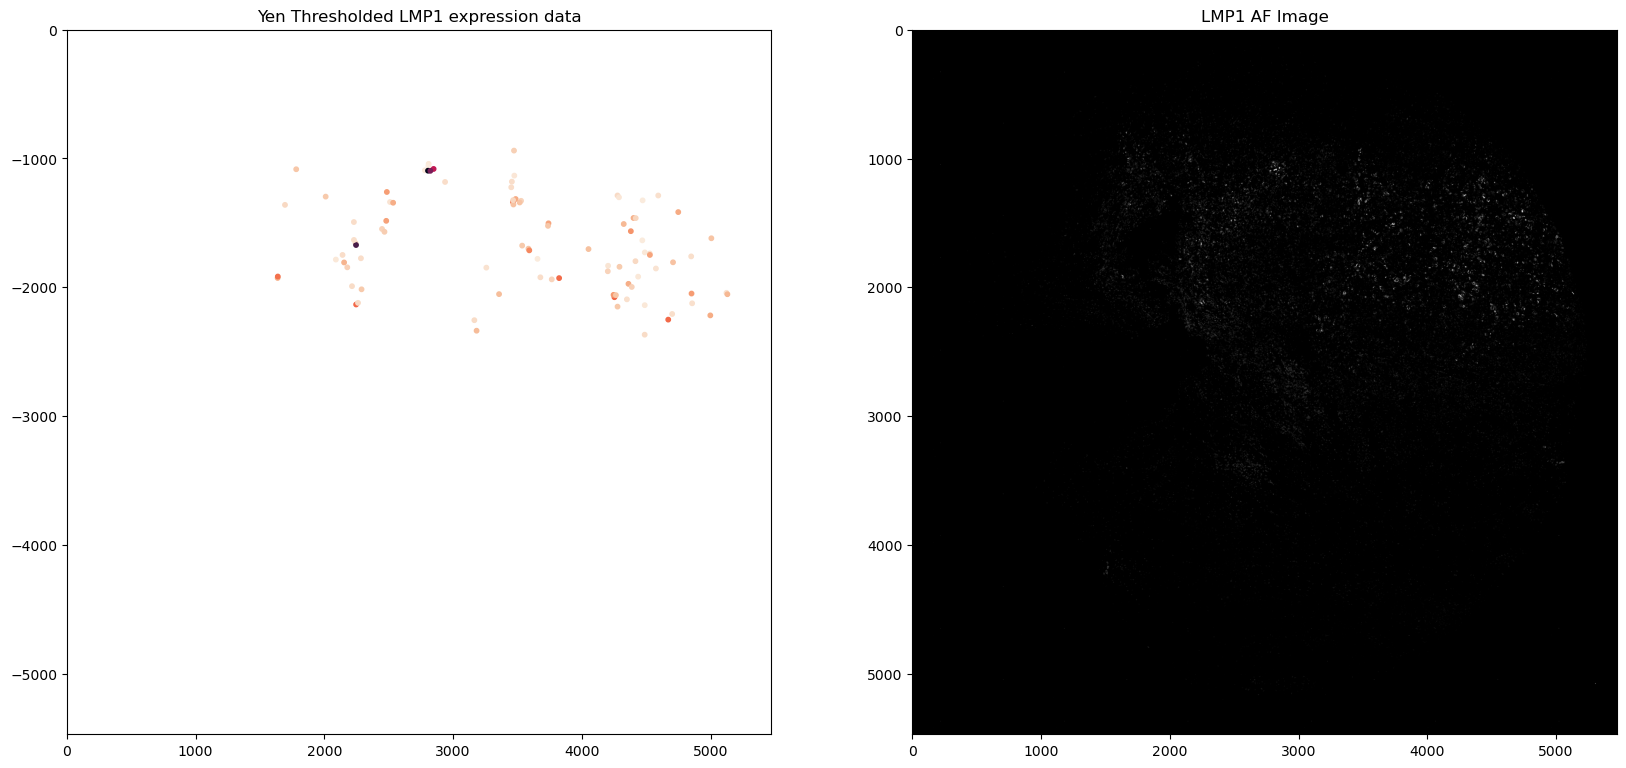

<Figure size 1000x800 with 0 Axes>

In [12]:

filtered_data = plot_data[plot_data['LMP1'] > 10 ** (thresh_yen + 1)]

fig, axes = plt.subplots(1,2, figsize=(20,10))

# 2. Create the scatter plot
plt.figure(figsize=(10, 8))

# x, y: coordinates
# c: the column to determine color (C1q)
# cmap: color map style (e.g., 'viridis', 'magma', 'coolwarm')
# s: size of the dots
axes[0].scatter(
    filtered_data['X_cent'], 
    -filtered_data['Y_cent'], 
    c=filtered_data['LMP1'], 
    cmap='rocket_r', 
    s=10, 
    alpha=1
)

axes[0].set_xlim(0, af_image.zimg_dict['LMP1'].shape[1]) # Width
axes[0].set_ylim(-af_image.zimg_dict['LMP1'].shape[0], 0) # Height (inverted 0 to max)
axes[0].set_aspect('equal') # Force pixels to be square
axes[0].set_title('Yen Thresholded LMP1 expression data')

axes[1].imshow(af_image.zimg_dict['LMP1'], cmap = 'gray', vmin = 0, vmax = 1000)
axes[1].set_title('LMP1 AF Image')

# Optional: Invert Y axis if your coordinates match image coordinates 
# (where (0,0) is usually top-left)
# plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [ ]:
annotation[annotation['LMP1_status'] == 'LMP1+']['TMA_crop'].unique()

array(['DFCI_c05', 'DFCI_c11', 'DFCI_c12', 'DFCI_C06', 'DFCI_c21',
       'Rochester_c11', 'Rochester_c16', 'Rochester_c23', 'Rochester_c28',
       'Rochester_C04'], dtype=object)

Run Yen thresholding on all LMP1+ cores and inspect the result. 

In [16]:
yen_dict = {}
# Create output directory
output_dir = "../data/LMP1_Analysis_Plots"
os.makedirs(output_dir, exist_ok=True)

# ROI List
roi_list = list(annotation[annotation['LMP1_status'] == 'LMP1+']['TMA_crop'].unique())

for roi in roi_list:
    print(f"Processing: {roi}...")
    
    tma, crop = roi.split('_')
    
    # --- 1. Filter Data ---
    plot_data = scaled_df[
        (scaled_df['TMA'] == tma) & 
        (scaled_df['cropName'] == crop)
    ]
    
    if plot_data.empty:
        print(f"  Skipping {roi}: No data found.")
        continue

    # --- 2. Calculations ---
    log_data = np.log10(plot_data['LMP1'] + 1e-6)
    thresh_yen = threshold_yen(log_data)
    yen_dict[roi] = thresh_yen
    filtered_data = plot_data[plot_data['LMP1'] > 10 ** thresh_yen]

    # --- 3. Setup Figure (Constrained Layout removes whitespace) ---
    fig = plt.figure(figsize=(16, 12), constrained_layout=True)
    
    # Create an outer grid with 2 rows: 
    # Row 0 (Top) is for histograms (shorter height)
    # Row 1 (Bottom) is for maps (taller height)
    outer_grid = gridspec.GridSpec(2, 1, figure=fig, height_ratios=[1, 2.5])
    
    fig.suptitle(f"Analysis for {roi}", fontsize=20, weight='bold')

    # --- TOP ROW: 3 Histograms ---
    # Create a 1x3 sub-grid inside the top row
    gs_top = outer_grid[0].subgridspec(1, 3)
    
    ax_hist1 = fig.add_subplot(gs_top[0])
    ax_hist2 = fig.add_subplot(gs_top[1])
    ax_hist3 = fig.add_subplot(gs_top[2])

    sns.histplot(plot_data['LMP1'], ax=ax_hist1)
    ax_hist1.set_title('Raw Distribution')

    sns.histplot(log_data, ax=ax_hist2)
    ax_hist2.set_title('Log10 Distribution')

    sns.histplot(log_data, ax=ax_hist3)
    ax_hist3.axvline(thresh_yen, color='black', linestyle='--', linewidth=2, label=f'Yen: {thresh_yen:.2f}')
    ax_hist3.set_title('Yen Threshold')
    ax_hist3.legend()

    # --- BOTTOM ROW: 2 Spatial Maps ---
    # Create a 1x2 sub-grid inside the bottom row
    gs_bottom = outer_grid[1].subgridspec(1, 2)
    
    ax_scatter = fig.add_subplot(gs_bottom[0])
    ax_image = fig.add_subplot(gs_bottom[1])

    try:
        img_path = f'../data/combined_img/{tma}/{crop}.ome.tiff'
        af_image = TiffZarrReader.from_ometiff(img_path)
        img_array = af_image.zimg_dict['LMP1']
        h, w = img_array.shape

        # Scatter Plot
        ax_scatter.scatter(
            filtered_data['X_cent'], 
            filtered_data['Y_cent'], 
            c=filtered_data['LMP1'], 
            cmap='rocket_r', 
            s=3, 
            alpha=0.7
        )
        ax_scatter.set_xlim(0, w)
        ax_scatter.set_ylim(h, 0) # Invert Y
        ax_scatter.set_aspect('equal')
        ax_scatter.set_title('Thresholded Points (Spatial)', fontsize=14)

        # Image Plot
        ax_image.imshow(img_array, cmap='gray', vmin=0, vmax=1000)
        ax_image.set_title('AF Image', fontsize=14)
        ax_image.set_aspect('equal')

    except Exception as e:
        ax_scatter.text(0.5, 0.5, "Error", ha='center')
        ax_image.text(0.5, 0.5, str(e), ha='center')

    # --- 4. Save ---
    save_path = os.path.join(output_dir, f"{roi}_analysis.png")
    plt.savefig(save_path, dpi=150) # constrained_layout handles the margins automatically
    plt.close(fig)

print("All plots saved with optimized layout.")


Processing: DFCI_c05...
Processing: DFCI_c11...
Processing: DFCI_c12...
Processing: DFCI_C06...
Processing: DFCI_c21...
Processing: Rochester_c11...
Processing: Rochester_c16...
Processing: Rochester_c23...
Processing: Rochester_c28...
Processing: Rochester_C04...
All plots saved with optimized layout.


Results from Yen thresholding looks good. Now we can classify cells into LMP1+ and LMP1-. 

In [17]:
scaled_df['TMA_crop'] = scaled_df['TMA'] + '_' + scaled_df['cropName']

df_list = []

for crop in scaled_df['TMA_crop'].unique():
    sub_df = scaled_df[scaled_df['TMA_crop'] == crop].copy()
    if crop in yen_dict.keys():
        if crop == 'Rochester_C04':
            yen_thresh = yen_dict[crop] + 1
        else:
            yen_thresh = yen_dict[crop]
        sub_df['LMP1_status_sC'] = np.where(sub_df['LMP1'] > 10 ** yen_thresh, 'LMP1+', 'LMP1-')
    else:
        sub_df['LMP1_status_sC'] = 'LMP1-'
    df_list.append(sub_df)

LMP1_sC_df = pd.concat(df_list)

LMP1_sC_df = LMP1_sC_df[['TMA', 'cropName', 'cellLabel', 'LMP1_status_sC']].copy()

LMP1_sC_df

,TMA,cropName,cellLabel,LMP1_status_sC
0,DFCI,c02,4,LMP1-
1,DFCI,c02,10,LMP1-
2,DFCI,c02,29,LMP1-
3,DFCI,c02,37,LMP1-
4,DFCI,c02,57,LMP1-
...,...,...,...,...
1509851,Rochester,C04,38903,LMP1-
1509852,Rochester,C04,38979,LMP1-
1509853,Rochester,C04,39373,LMP1-
1509854,Rochester,C04,39427,LMP1-


## Format data for network analysis
Create a dataframe for hop analysis with new columns `LMP1_status_sC`, `C1q_status` and filter to only B cell, CD4 T, and macrophage.

In [19]:
hop_df = annotation.merge(macro_df[['TMA', 'cropName', 'cellLabel', 'C1q_status_sC']],
                          on = ['TMA', 'cropName', 'cellLabel'],
                          how = 'left')

hop_df = hop_df.copy().merge(LMP1_sC_df,
                             on = ['TMA', 'cropName', 'cellLabel'],
                             how = 'left')

hop_df['C1q_status_sC'] = hop_df['C1q_status_sC'].fillna('Not Macrophage')

hop_df = hop_df[~hop_df['Annotation'].isin(['Others'])]

hop_df = hop_df[~(hop_df['TMA_crop'].isin(['DFCI_c05', 'Rochester_c22', 'DFCI_c21', 'DFCI_c41']))] # C1q didn't work in DFCI_c05


In [20]:
hop_df['Annotation'] = np.where(hop_df['Annotation'] == 'Macrophage', hop_df['C1q_status_sC'] + ' ' + 'Macrophage', hop_df['Annotation'])

## Build network

In [21]:
celltype_color = {
    'B cell': '#F781BF',
    'CD4 T': '#4DAF4A',
    'CD8 T': '#984EA3',
    'C1q+ Macrophage': '#F7C173',
    'C1q- Macrophage': "#220FCC",
    'Others': 'gray',
    'Stromal': 'red',
    "Treg" : "#9ED900",
}

# Function to get one-hop and two-hop neighbors for a given node
def get_neighbors(graph, node):
    # Get one-hop neighbors
    one_hop_neighbors = list(graph.neighbors(node))
    
    # Get two-hop neighbors
    two_hop_neighbors = set()
    for neighbor in one_hop_neighbors:
        two_hop_neighbors.update(graph.neighbors(neighbor))
    
    # Remove the original node and one-hop neighbors from the two-hop neighbors
    two_hop_neighbors.discard(node)
    two_hop_neighbors.difference_update(one_hop_neighbors)
    
    return one_hop_neighbors, list(two_hop_neighbors)

def within_threshold(p1, p2, mpp, threshold = 100):
    distance = np.linalg.norm(p1 - p2) * mpp
    return (distance <= threshold)

In [22]:
graph_dict = {}

count_df_dict = {}

for core in tqdm(hop_df['TMA_crop'].unique()):
    # print(f'Working on {core}...')
    # Create a new figure for each core
    fig, ax = plt.subplots(figsize=(20, 20))

    # subset data
    sub_df = hop_df.loc[hop_df['TMA_crop'] == core] 
    sub_df = sub_df.loc[~sub_df['Annotation'].isin(['Others'])]
    pts = sub_df.loc[:,['X_cent', 'Y_cent']].values
    sub_df_reindex = sub_df.reset_index(drop = True)

    # Delaunay triangulation
    tri = Delaunay(points = pts)
    
    # Create a graph from the triangulation
    G = nx.Graph()
    G.add_nodes_from(range(len(pts)))
    MPP = 0.5 # micron per pixel
    THRESHOLD = 20 # only connect nodes if they are within 20um of each other 
    for simplex in tri.simplices:
        if within_threshold(pts[simplex[0]], pts[simplex[1]], mpp = MPP, threshold = THRESHOLD):
            G.add_edge(simplex[0], simplex[1])
        if within_threshold(pts[simplex[1]], pts[simplex[2]], mpp = MPP, threshold = THRESHOLD):
            G.add_edge(simplex[1], simplex[2])
        if within_threshold(pts[simplex[2]], pts[simplex[0]], mpp = MPP, threshold = THRESHOLD):
            G.add_edge(simplex[2], simplex[0])
    # print(f'Nodes in Graph match rows in dataframe: {G.number_of_nodes() == sub_df.shape[0]}')

    # append graph to graph dict

    graph_dict[core] = G

    # position of the nodes for plotting
    pos = dict(zip(range(len(pts)), pts))

    # Convert positions to a numpy array for easy transformation
    pos_array = np.array([coords for coords in pos.values()])

    # Reflect the graph about the x-axis (flip y-coordinates)
    reflected_array = pos_array * [1, -1]

    # Create a new position dictionary from the reflected array
    reflected_pos = dict(zip(pos.keys(), reflected_array))

    output = '../data/hop_analysis_010126/graph_20um'

    os.makedirs(output, exist_ok=True)

    # Create a list of colors for each node based on its annotation
    node_colors = [celltype_color[annotation] for annotation in sub_df['Annotation']]

    # plot the graph
    nx.draw_networkx_nodes(G, pos=reflected_pos, node_size=15, node_color=node_colors, ax=ax)
    nx.draw_networkx_edges(G, pos=reflected_pos, edge_color='white', alpha=0.8, ax=ax)
    
    # Create legend
    legend_handles = []
    legend_labels = []

    # Iterate over the cell types and colors present in this core
    for celltype in sub_df['Annotation'].unique():
        color = celltype_color[celltype]
        # Create a Patch for each cell type
        patch = Patch(color=color, label=celltype)
        legend_handles.append(patch)
        legend_labels.append(celltype)

    # Create the legend
    ax.legend(handles=legend_handles, labels=legend_labels, loc='center left', bbox_to_anchor=(1, 0.5), fontsize='medium', frameon = False, labelcolor = 'white', prop = {'weight': 'bold'})

    ax.set_title(f'Cell Graph for Core: {core}')
    ax.axis('equal')
    ax.axis('off')

    plt.tight_layout()
    plt.savefig(f'../data/hop_analysis_010126/graph_20um/{core}.png',
                dpi=200,
                facecolor='black',
                pad_inches=0)
    plt.close()

    # Create a dict to store the 1-hop, 2-hop neighbors

    neighbors_dict = {}

    for node in G.nodes():
        neighbors_dict[node] = {}
        one_hop, two_hop = get_neighbors(G, node)
        neighbors_dict[node]['one hop'] = one_hop
        neighbors_dict[node]['two hop'] = two_hop

    cellLabel_neighbors_dict = {}

    for key, item in neighbors_dict.items():
        new_key = sub_df_reindex['cellLabel'][key]
        cellLabel_neighbors_dict[new_key] = {}
        one_hop_cellLabel = str(sub_df_reindex['cellLabel'][item['one hop']].values)
        two_hop_cellLabel = str(sub_df_reindex['cellLabel'][item['two hop']].values)
        cellLabel_neighbors_dict[new_key]['one hop'] = one_hop_cellLabel
        cellLabel_neighbors_dict[new_key]['two hop'] = two_hop_cellLabel


    LUT_df = pd.DataFrame([(key, item['one hop'], item['two hop']) for key, item in cellLabel_neighbors_dict.items()],
                                columns=['cellLabel', 'one_hop', 'two_hop'])
    
    output = '../data/hop_analysis_010126/LUT'

    os.makedirs(output, exist_ok=True)

    LUT_df.to_csv(f'{output}/{core}.csv', index=False)

    # Anchor on each celltype and check its neighbors

    count_df_dict[core] = {}

    for i in sub_df_reindex['Annotation'].unique():
        idx = sub_df_reindex[sub_df_reindex['Annotation'] == i].index
        celltype_df = sub_df_reindex.iloc[idx]
        count_df_dict[core][i] = {}
        count_dict_one_hop = {}
        count_dict_two_hop = {}
        count_dict_one_and_two = {}
        for j in idx:
            one_hop = neighbors_dict[j]['one hop']
            two_hop = neighbors_dict[j]['two hop']
            
            j_df_one_hop = sub_df_reindex['Annotation'][one_hop]
            iter_counts_one_hop = Counter(j_df_one_hop)
            count_dict_one_hop[sub_df_reindex['cellLabel'][j]] = iter_counts_one_hop
            
            j_df_two_hop = sub_df_reindex['Annotation'][two_hop]
            iter_counts_two_hop = Counter(j_df_two_hop)
            count_dict_two_hop[sub_df_reindex['cellLabel'][j]] = iter_counts_two_hop

            j_df_one_and_two = sub_df_reindex['Annotation'][[i for i in one_hop + two_hop]]
            iter_counts_one_and_two = Counter(j_df_one_and_two)
            count_dict_one_and_two[sub_df_reindex['cellLabel'][j]] = iter_counts_one_and_two
        count_df_one_hop = pd.DataFrame(count_dict_one_hop).transpose().fillna(0)
        count_df_two_hop = pd.DataFrame(count_dict_two_hop).transpose().fillna(0)
        count_df_one_and_two = pd.DataFrame(count_dict_one_and_two).transpose().fillna(0)

        count_df_dict[core][i]['one_hop'] = count_df_one_hop
        count_df_dict[core][i]['two_hop'] = count_df_two_hop
        count_df_dict[core][i]['one_and_two'] = count_df_one_and_two

with open('../data/hop_analysis_010126/count_df_dict_ROI.pkl', 'wb') as handle:
    pickle.dump(count_df_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('../data/hop_analysis_010126/graph_dict_ROI.pkl', 'wb') as handle:
    pickle.dump(graph_dict, handle, protocol=pickle.HIGHEST_PROTOCOL) 

100%|██████████| 35/35 [32:49<00:00, 56.28s/it]


In [ ]:
B_df = hop_df[hop_df['Annotation'] == 'B cell']


Do LMP1+ B cells have more C1q+ macrophages in their 1-hop neighborhood?

- Iterate through all B cells.
- Calculate the proportion of C1q+ macrophages in their 1-hop neighborhood.
- Log(Proportion of C1q+ macrophage) ~ C(EBV) + C(TMA) + C(is 1-hop neighbor to LMP1+ B cell)

In [31]:
with open('../data/hop_analysis_010126/count_df_dict_ROI.pkl', 'rb') as f:
    count_df_dict = pickle.load(f)  

with open('../data/hop_analysis_010126/graph_dict_ROI.pkl', 'rb') as f:
    graph_dict = pickle.load(f)

In [32]:
cell_ls = []
for core in hop_df['TMA_crop'].unique():
    df = pd.concat([count_df_dict[core]['B cell']['one_hop']])
    df.index = [f"{core}_{i}" for i in df.index]
    cell_ls.append(df)

cell_count = pd.concat(cell_ls).fillna(0)

cell_ls_two_hop = []
for core in hop_df['TMA_crop'].unique():
    df = pd.concat([count_df_dict[core]['B cell']['two_hop']])
    df.index = [f"{core}_{i}" for i in df.index]
    cell_ls_two_hop.append(df)
cell_count_two_hop = pd.concat(cell_ls_two_hop).fillna(0)

cell_ls_one_and_two = []
for core in hop_df['TMA_crop'].unique():
    df = pd.concat([count_df_dict[core]['B cell']['one_and_two']])
    df.index = [f"{core}_{i}" for i in df.index]
    cell_ls_one_and_two.append(df)
cell_count_one_and_two = pd.concat(cell_ls_one_and_two).fillna(0)

In [33]:
cell_count_scaled = cell_count.copy()
cell_count_two_hop_scaled = cell_count_two_hop.copy()
cell_count_one_and_two_scaled = cell_count_one_and_two.copy()

cell_count_scaled = cell_count_scaled.div(cell_count_scaled.sum(axis = 1), axis=0).fillna(0)
cell_count_two_hop_scaled = cell_count_two_hop_scaled.div(cell_count_scaled.sum(axis = 1), axis=0).fillna(0)
cell_count_one_and_two_scaled = cell_count_one_and_two_scaled.div(cell_count_scaled.sum(axis = 1), axis=0).fillna(0)

In [34]:
cell_count_scaled[['TMA', 'cropName', 'cellLabel']] = cell_count_scaled.index.to_series().str.split('_', expand=True)
cell_count_scaled['cellLabel'] = cell_count_scaled['cellLabel'].astype(int)

In [35]:
cell_count_scaled = cell_count_scaled.merge(B_df[['TMA', 'cropName', 'cellLabel', 'LMP1_status_sC', 'EBV']],
                                            on = ['TMA', 'cropName', 'cellLabel'],
                                            how = 'left')

In [36]:
cell_count_scaled

,C1q+ Macrophage,CD8 T,B cell,CD4 T,Stromal,C1q- Macrophage,Treg,TMA,cropName,cellLabel,LMP1_status_sC,EBV
0,0.666667,0.333333,0.000000,0.000000,0.000000,0.0,0.0,DFCI,c02,4,LMP1-,EBV+
1,0.333333,0.000000,0.333333,0.333333,0.000000,0.0,0.0,DFCI,c02,10,LMP1-,EBV+
2,0.500000,0.500000,0.000000,0.000000,0.000000,0.0,0.0,DFCI,c02,29,LMP1-,EBV+
3,0.000000,1.000000,0.000000,0.000000,0.000000,0.0,0.0,DFCI,c02,37,LMP1-,EBV+
4,0.250000,0.250000,0.250000,0.000000,0.250000,0.0,0.0,DFCI,c02,57,LMP1-,EBV+
...,...,...,...,...,...,...,...,...,...,...,...,...
456571,0.000000,0.400000,0.000000,0.200000,0.000000,0.0,0.4,Rochester,C04,22976,LMP1-,EBV+
456572,0.000000,0.000000,0.200000,0.400000,0.000000,0.0,0.4,Rochester,C04,28115,LMP1-,EBV+
456573,0.000000,0.200000,0.000000,0.000000,0.800000,0.0,0.0,Rochester,C04,32233,LMP1-,EBV+
456574,0.142857,0.000000,0.000000,0.142857,0.714286,0.0,0.0,Rochester,C04,33041,LMP1-,EBV+


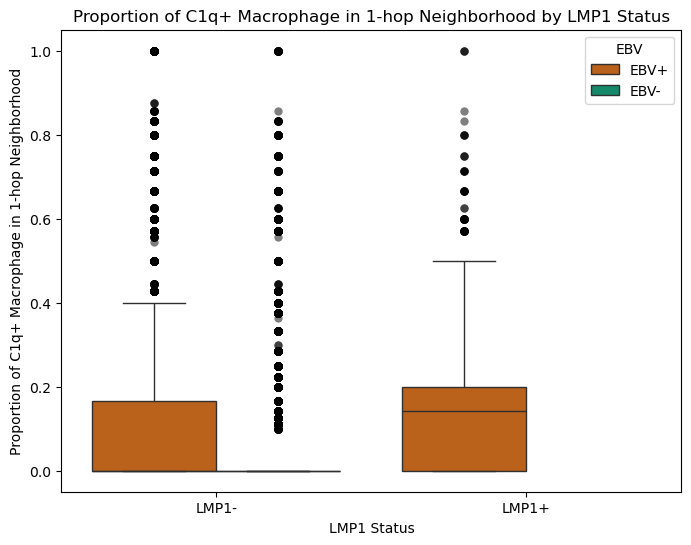

In [37]:
color_palette = {'EBV+': '#D55E00', 'EBV-': '#009E73'}
outlier_props = dict(marker='o', markerfacecolor='black', markeredgecolor='none', alpha=0.5)
plt.figure(figsize=(8, 6))
sns.boxplot(x='LMP1_status_sC', y='C1q+ Macrophage', hue='EBV', data=cell_count_scaled, palette=color_palette, flierprops = outlier_props)
# plt.yscale('log') # Log scale helps visualize ratios better
plt.ylabel('Proportion of C1q+ Macrophage in 1-hop Neighborhood')
plt.xlabel('LMP1 Status')
plt.title('Proportion of C1q+ Macrophage in 1-hop Neighborhood by LMP1 Status')
plt.savefig('../data/fig6_output_plots/LMP1_C1q_mac_1hop/boxplot.pdf', bbox_inches = 'tight')
plt.show()


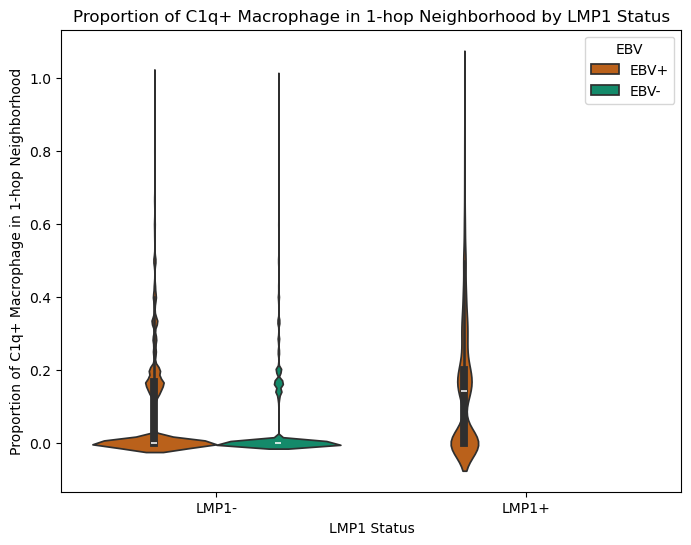

In [38]:
plt.figure(figsize=(8, 6))

ax = sns.violinplot(x='LMP1_status_sC', y='C1q+ Macrophage', hue='EBV', 
                    data=cell_count_scaled, palette=color_palette, inner='box')

plt.ylabel('Proportion of C1q+ Macrophage in 1-hop Neighborhood')
plt.xlabel('LMP1 Status')
plt.title('Proportion of C1q+ Macrophage in 1-hop Neighborhood by LMP1 Status')
plt.savefig('../data/fig6_output_plots/LMP1_C1q_mac_1hop/violin_boxplot.pdf', bbox_inches='tight')
plt.show()

In [39]:
cell_count_scaled['log_proportion'] = np.log10(cell_count_scaled['C1q+ Macrophage'] + 1e-6)

def define_status(row):
    if row['EBV'] == 'EBV-':
        return 'EBV_Neg'
    elif row['LMP1_status_sC'] == 'LMP1-':
        # We know EBV is + here because the first check failed
        return 'EBV_Pos_LMP1_Neg'
    else:
        return 'EBV_Pos_LMP1_Pos'

cell_count_scaled['Viral_Status'] = cell_count_scaled.apply(define_status, axis=1)

formula = 'log_proportion ~ C(TMA) + C(Viral_Status, Treatment(reference="EBV_Neg"))'

# Fit the Ordinary Least Squares (OLS) model
model = smf.ols(formula, data=cell_count_scaled).fit()

# Perform Type II ANOVA
anova_table = sm.stats.anova_lm(model, typ=2)


print(model.summary())

                            OLS Regression Results                            
Dep. Variable:         log_proportion   R-squared:                       0.035
Model:                            OLS   Adj. R-squared:                  0.035
Method:                 Least Squares   F-statistic:                     5530.
Date:                Fri, 16 Jan 2026   Prob (F-statistic):               0.00
Time:                        10:24:02   Log-Likelihood:            -1.0062e+06
No. Observations:              456576   AIC:                         2.012e+06
Df Residuals:                  456572   BIC:                         2.013e+06
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                                                          coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------

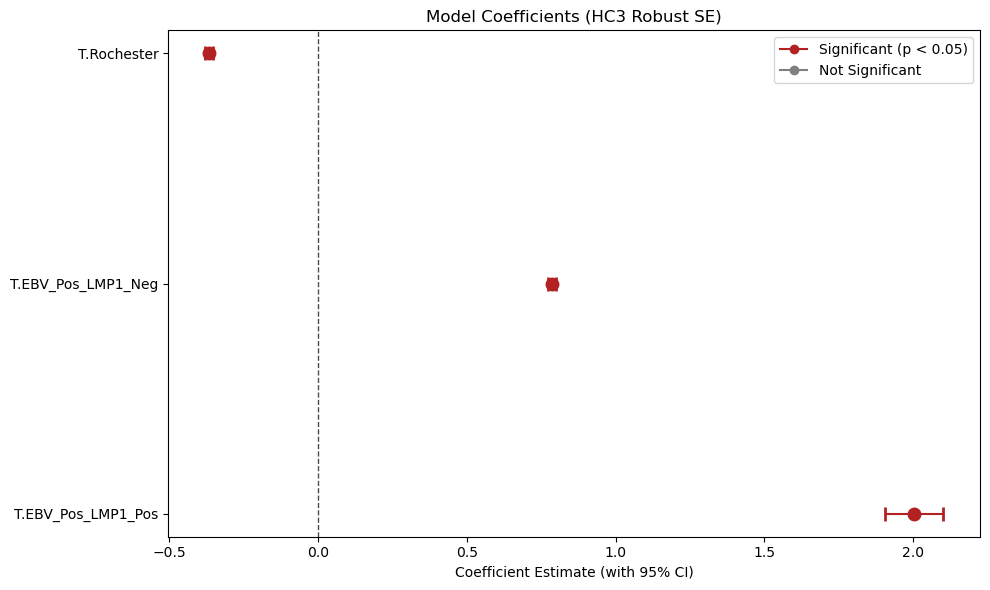

In [40]:
plot_coefficients_clean(model)
plt.savefig('../data/fig6_output_plots/LMP1_C1q_mac_1hop/coefficient.pdf',bbox_inches='tight')
plt.show()

1. EBV+ cores in general have higher proportion of C1q+ macrophages in the 1-hop neighborhood of B cells.
2. Among EBV+ cores, LMP1+ B cells have even higher proportion of C1q+ macrophages in their 1-hop neighborhood. 

2. Holding all other variables constant, on average, the proportion of C1Q+ macropahge in the 1-hop neighbors of LMP1+ tumors in an EBV+ cores has an estimated log10-fold change of 2, which is statistically significant at $\alpha = 0.05$, with a 95% CI of $[1.91, 2.10]$. 